# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

Recall the Lab from last lesson on Logistic Regression. We will be revisting the ideas introduced using the Titanic dataset again.

For a description of the Titanic dataset see this Kaggle page: https://www.kaggle.com/c/titanic/data

In [2]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived
#X = ___
#y = ___

# TASK 3: split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK 4: fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

0.6681614349775785


### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [3]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.4260089686098655
0.5739910313901345


In [4]:
# equivalent function in scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print (metrics.accuracy_score(y_test, y_dumb_class))

0.5739910313901345


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [5]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
# get dimensions of entire titanic df

titanic.shape

(891, 11)

In [8]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [9]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [10]:
# fill missing values for Age with the mean age
titanic['Age_filled'] = titanic.Age.fillna(titanic.Age.mean())

In [11]:
# check that fillna worked

titanic.isnull().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age           177
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         687
Embarked        2
Age_filled      0
dtype: int64

In [12]:
# Check first 10 values for age

titanic[['Age', 'Age_filled']].head(10)

,Age,Age_filled
PassengerId,,
1,22.0,22.000000
2,38.0,38.000000
3,26.0,26.000000
4,35.0,35.000000
5,35.0,35.000000
6,NaN,29.699118
7,54.0,54.000000
8,2.0,2.000000
9,27.0,27.000000


In [13]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)

titanic['Age_impute'] = imp.fit_transform(titanic.Age.values.reshape(1,-1)).T

In [14]:
# Sanity check

titanic[['Age', 'Age_filled', 'Age_impute']].loc[titanic['Age'].isnull()].head(10)

,Age,Age_filled,Age_impute
PassengerId,,,
6,NaN,29.699118,29.699118
18,NaN,29.699118,29.699118
20,NaN,29.699118,29.699118
27,NaN,29.699118,29.699118
29,NaN,29.699118,29.699118
30,NaN,29.699118,29.699118
32,NaN,29.699118,29.699118
33,NaN,29.699118,29.699118
37,NaN,29.699118,29.699118


In [15]:
# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age_filled']
X = titanic[feature_cols]

from sklearn.model_selection import train_test_split

# TASK : split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# TASK : fit a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
# TASK : make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
print (metrics.accuracy_score(y_test, y_pred_class))

0.672645739910314


## Part 2: Confusion Matrix

In [16]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [17]:
# %load confusion_matrix_nice.py
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
#from sklearn.model_selection import train_test_split # from sklearn version 0.18
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[107  21]
 [ 52  43]]


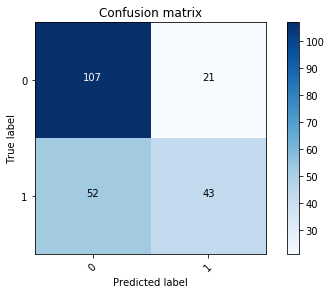

In [18]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [19]:
# calculate the sensitivity / true positive rate
43 / float(52 + 43)

0.45263157894736844

In [20]:
# calculate the specificity / true negative rate
107 / float(107 + 21)

0.8359375

In [21]:
logreg.predict_proba(X_test)

array([[0.47498169, 0.52501831],
       [0.80897755, 0.19102245],
       [0.47270882, 0.52729118],
       [0.80897755, 0.19102245],
       [0.27271226, 0.72728774],
       [0.75629647, 0.24370353],
       [0.51834188, 0.48165812],
       [0.36244541, 0.63755459],
       [0.30683877, 0.69316123],
       [0.80897755, 0.19102245],
       [0.78167217, 0.21832783],
       [0.78771002, 0.21228998],
       [0.52853848, 0.47146152],
       [0.58530324, 0.41469676],
       [0.80897755, 0.19102245],
       [0.30683877, 0.69316123],
       [0.55604111, 0.44395889],
       [0.77551153, 0.22448847],
       [0.84138487, 0.15861513],
       [0.34740645, 0.65259355],
       [0.82136336, 0.17863664],
       [0.78771002, 0.21228998],
       [0.27729948, 0.72270052],
       [0.48162474, 0.51837526],
       [0.71098576, 0.28901424],
       [0.79362497, 0.20637503],
       [0.17088695, 0.82911305],
       [0.68658585, 0.31341415],
       [0.55289611, 0.44710389],
       [0.26320525, 0.73679475],
       [0.

In [22]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

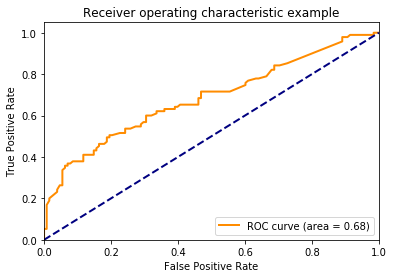

In [23]:
# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr,tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

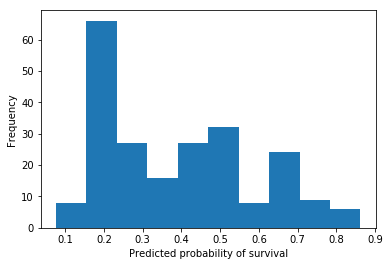

In [24]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

plt.show()

In [25]:
# Calculate actual survival rate

survival_rate = titanic['Survived'].sum() / titanic.shape[0]
print(survival_rate)

0.3838383838383838


In [26]:
# change the threshold for predicting survived to increase sensitivity
# range of probabilities have been calculated, but survival defined as 0 = not survived, 1 = survived
import numpy as np

# where probability is more than actual survival rate, change to 1
y_pred_class = np.where(y_pred_prob > survival_rate, 1, 0) 

In [27]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1), survival_rate).T

In [28]:
# new confusion matrix
print (metrics.confusion_matrix(y_test, y_pred_class))

[[81 47]
 [35 60]]


In [29]:
# new sensitivity
print (60 / float(35 + 60))

0.631578947368421


In [30]:
# new specificity
print (47 / float(47 + 81))

0.3671875


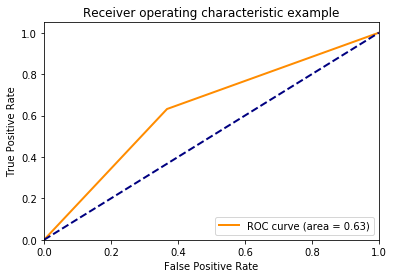

In [31]:
# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_class)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr,tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Part 3: Cross Validation Example on Bike Share

#### Intro to cross validation with bike share data

In [32]:
from sklearn import cross_validation
bikeshare = pd.read_csv('bikeshare.csv')

In [33]:
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Create dummy variables and set outcome (dependent) variable

In [34]:
# Create dummy variables for weather

weather = pd.get_dummies(bikeshare.weathersit, prefix='weather') 
weather.head()

,weather_1,weather_2,weather_3,weather_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [35]:
# Make feature table

modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
modeldata.head()

,temp,hum,weather_1,weather_2,weather_3
0,0.24,0.81,1,0,0
1,0.22,0.80,1,0,0
2,0.22,0.80,1,0,0
3,0.24,0.75,1,0,0
4,0.24,0.75,1,0,0


In [36]:
# Choose outcome variable

y = bikeshare.casual

#### Create a cross validation with 5 folds

In [37]:
from sklearn import linear_model

In [43]:
help(cross_validation.KFold)

Help on class KFold in module sklearn.cross_validation:

class KFold(_BaseKFold)
 |  K-Folds cross validation iterator.
 |  
 |  .. deprecated:: 0.18
 |      This module will be removed in 0.20.
 |      Use :class:`sklearn.model_selection.KFold` instead.
 |  
 |  Provides train/test indices to split data in train test sets. Split
 |  dataset into k consecutive folds (without shuffling by default).
 |  
 |  Each fold is then used as a validation set once while the k - 1 remaining
 |  fold(s) form the training set.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n : int
 |      Total number of elements.
 |  
 |  n_folds : int, default=3
 |      Number of folds. Must be at least 2.
 |  
 |  shuffle : boolean, optional
 |      Whether to shuffle the data before splitting into batches.
 |  
 |  random_state : int, RandomState instance or None, optional, default=None
 |      If int, random_state is the seed used by the random number
 |  

In [40]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

sklearn.cross_validation.KFold(n=17379, n_folds=5, shuffle=True, random_state=None)


In [50]:
# Check out training and test indices for each fold

for train_index, text_index in kf:
    print('TRAIN:', train_index, len(train_index))
    print('TEST:', test_index, len(test_index))

TRAIN: [    0     1     2 ... 17375 17376 17378] 13903
TEST: [    6    10    13 ... 17371 17374 17375] 3475
TRAIN: [    0     1     2 ... 17376 17377 17378] 13903
TEST: [    6    10    13 ... 17371 17374 17375] 3475
TRAIN: [    3     4     5 ... 17374 17375 17377] 13903
TEST: [    6    10    13 ... 17371 17374 17375] 3475
TRAIN: [    0     1     2 ... 17376 17377 17378] 13903
TEST: [    6    10    13 ... 17371 17374 17375] 3475
TRAIN: [    0     1     2 ... 17376 17377 17378] 13904
TEST: [    6    10    13 ... 17371 17374 17375] 3475


In [44]:
mse_values = [] # list to store mean squared error
scores = [] # list to store model scores (R^2)

n= 0 # initialise n

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index]) # fit linear regression
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index]))) # append mse to mse list
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1583.3067901919578
R2: 0.3119203500217872
Model 2
MSE: 1819.4364130848203
R2: 0.31187794722284634
Model 3
MSE: 1714.1340180678765
R2: 0.3119202775364399
Model 4
MSE: 1506.5594301010585
R2: 0.31189336760639697
Model 5
MSE: 1742.3777706074518
R2: 0.3119289045743018
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.162884410633
Mean of R2 for all folds: 0.3119081693923544


In [51]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print ("~~~~ Single Model ~~~~")
print ('MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata)))
print ('R2: ', lm.score(modeldata, y))

~~~~ Single Model ~~~~
MSE of single model: 1672.5811076539346
R2:  0.31193460598906453


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

The cross-validated, averaged model would predict new data more accurately than the single model as the mean MSE of cross-validated model has been calculated by comparing predicted and actual values of test data K number of times, while the MSE of the single model represents training error, which is usually lower than test error, and the single model has not been tested on new data.

## Part 4: Apply Cross Validation to the Titanic Dataset

In [52]:
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

In [53]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [57]:
# Inpute age
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)

titanic['Age_impute'] = imp.fit_transform(titanic.Age.values.reshape(1,-1)).T

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [59]:
feature_cols = ['Pclass', 'Parch', 'Age_impute']
X = titanic[feature_cols]
y = titanic.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
print(list(zip(feature_cols, logreg.coef_[0])))

[('Pclass', -1.0987976793837215), ('Parch', 0.25711996436909657), ('Age_impute', -0.0357391655634235)]


In [61]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.cross_validation:

cross_val_score(estimator, X, y=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    Evaluate a score by cross-validation
    
    .. deprecated:: 0.18
        This module will be removed in 0.20.
        Use :func:`sklearn.model_selection.cross_val_score` instead.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like
        The data to fit. Can be, for example a list, or an array at least 2d.
    
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    
    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
 

In [62]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print (scores)
print (scores.mean())

[0.64444444 0.62222222 0.68539326 0.69662921 0.71910112 0.69662921
 0.76404494 0.74157303 0.73033708 0.72727273]
0.7027647259107933


### Task: Evaluate each stage of the model with Cross-Validation

In [63]:
titanic_kf = cross_validation.KFold(len(X), n_folds=10, shuffle=True)

In [67]:
mse_values = [] # list to store mean squared error
scores = [] # list to store model scores (R^2)

n= 0 # initialise n

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in titanic_kf:
    logR = LogisticRegression().fit(X.iloc[train_index], y.iloc[train_index]) # fit linear regression
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], logR.predict(X.iloc[test_index]))) # append mse to mse list
    scores.append(logR.score(X, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('Score:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of score for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.26666666666666666
Score: 0.7070707070707071
Model 2
MSE: 0.29213483146067415
Score: 0.7115600448933782
Model 3
MSE: 0.2696629213483146
Score: 0.7149270482603816
Model 4
MSE: 0.33707865168539325
Score: 0.7115600448933782
Model 5
MSE: 0.20224719101123595
Score: 0.7059483726150393
Model 6
MSE: 0.23595505617977527
Score: 0.7070707070707071
Model 7
MSE: 0.25842696629213485
Score: 0.7048260381593715
Model 8
MSE: 0.34831460674157305
Score: 0.7037037037037037
Model 9
MSE: 0.4044943820224719
Score: 0.7037037037037037
Model 10
MSE: 0.3146067415730337
Score: 0.7093153759820426
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.29295880149812736
Mean of score for all folds: 0.7079685746352413


### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)

In [70]:
cv = [2, 5, 10, 50, 100]
scores_list = []
mean_scores = []

for fold in cv:
    scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=fold)
    scores_list.append(scores)
    mean_scores.append(scores.mean())
    
print(mean_scores)    

[0.6947523555197259, 0.7015657920261352, 0.7027647259107933, 0.7086764705882354, 0.712361111111111]


### Task: Experiment with differen model evaluation metrics form sci-kit learn

See a list of model evaluatin metrics here. Particulary try precision and recall and f1. Read about available methods and what they mean here:
http://scikit-learn.org/stable/modules/model_evaluation.html

